In [1]:
import cv2
import tensorflow as tf
import os
import numpy as np
import network as net
from Training import openpose
import matplotlib.pyplot as plt
from scipy.ndimage.filters import maximum_filter
import math
from collections import Counter, defaultdict
import itertools
import matplotlib as mpl
import time
import ast
from scipy.ndimage.filters import gaussian_filter

C:\Users\JAEKYU\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Open Pose Class Loading Finish


Function Load

In [2]:
def make_test_batch(img_path, batch_size):
    num_of_data = len(img_path)
    index = np.arange(0, num_of_data)
    np.random.shuffle(index)
    index = index[:batch_size]
    
    shuffled_img_data = [img_path[i] for i in index]
    
    return np.asarray(shuffled_img_data)

def path_to_image(img_path, batch_size):
    #buffer 선언
    image_data = np.zeros((batch_size, 356, 356, 3), np.uint8)
    
    index = 0
    for img in (img_path):
        #buffer = cv2.imread(img)
        #buffer = cv2.resize(buffer, (526, 526))
        #image_data[index] = buffer
        #index = index + 1
        #buffer = cv2.resize(buffer, (526, 526))

        image_data[index] = cv2.imread(img)
        index = index + 1

    return image_data

def load_test_data(save_path):
    img_path = save_path#"./MPII_Dataset/resized_test_image/"
    file_path = []
    file_list = os.listdir(img_path)
    for i in (file_list):
        file_path.append(img_path + i)
    return file_path

In [3]:
MPII_Pairs = [(9, 8), (8, 13), (8, 12), (8, 7), (12, 11), (11, 10), (13, 14), (14, 15), \
              (7, 6), (6, 3), (3, 4), (4, 5), (6, 2), (2, 1), (1, 0)]#16개 조인트, 15개 limb
MPII_Pairs_Render = MPII_Pairs[:]
MPII_Pairs_Network = [(0, 1), (2, 3), (4, 5), (6, 7), (12, 13), (14, 15), (8, 9), (10, 11), (16, 17), (18, 19),\
                     (22, 23), (24, 25), (20, 21), (26, 27), (28, 29)]#x, y vectormap Pairs 24,25

MPII_Colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0],\
              [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255],\
              [170, 0, 255], [170, 0, 255],[170, 0, 255]]

InterMinAbove_Threshold = 6
Inter_Threashold = 1e-08#0.1
Min_Subset_Cnt = 0#4
Min_Subset_Score = 0.01#0.8
#Max_Human = 96
def non_max_suppression(np_input, window_size=5, threshold=0.1):
    under_threshold_indices = np_input < threshold
    np_input[under_threshold_indices] = 0
    return np_input*(np_input == maximum_filter(np_input, footprint=np.ones((window_size, window_size))))

def estimate_pose(coords, heatmap_buffer, heatmap, vectormap):
    """
    [(12, 11), (11, 10), (13, 14), (14, 15)]
    0 - r_ankle
    1 - r_knee
    2 - r_hip
    3 - l_hip
    4 - l_knee
    5 - l_ankle
    6 - pelvis
    7 - thorax
    8 - upper neck
    9 - head top
    10 - r_wrist
    11 - r_elbow
    12 - r_sholder
    13 - l_sholder
    14 - l_elbow
    15 - l_wrist
    16 - back_ground
    """

    connection_all = []
    for (idx1, idx2), (paf_x_idx, paf_y_idx) in zip(MPII_Pairs, MPII_Pairs_Network):
        print("idx1, idx2 : ", idx1, idx2)
        print("paf_x_idx, paf_y_idx : ", paf_x_idx, paf_y_idx)
        connection = estimate_pose_pair(coords, idx1, idx2, vectormap[paf_x_idx], vectormap[paf_y_idx])
        #print("estimate_pose -> idx1, idx2 : ",idx1, idx2)
        #estimate_pose_pair(coords, idx1, idx2, vectormap[paf_x_idx], vectormap[paf_y_idx])
        connection_all.extend(connection)

    print("connection_all : ", connection_all)
    connection_by_human = dict()
    for idx, c in enumerate(connection_all):
        connection_by_human['human_%d' % idx] = [c]
    print("connection_by_human : ", connection_by_human)
    no_merge_cache = defaultdict(list)

    while True:
        is_merged = False
        for k1, k2 in itertools.combinations(connection_by_human.keys(), 2):
            if k1 == k2:
                continue
            if k2 in no_merge_cache[k1]:
                continue
            for c1, c2 in itertools.product(connection_by_human[k1], connection_by_human[k2]):
                if len(set(c1['uPartIdx']) & set(c2['uPartIdx'])) > 0:
                    is_merged = True
                    connection_by_human[k1].extend(connection_by_human[k2])
                    connection_by_human.pop(k2)
                    break
            if is_merged:
                no_merge_cache.pop(k1, None)
                break
            else:
                no_merge_cache[k1].append(k2)

        if not is_merged:
            break


    connection_by_human = {k: v for (k, v) in connection_by_human.items() if len(v) >= Min_Subset_Cnt}
    # reject by subset max score
    print("connection_by_human2 : ", connection_by_human)
    connection_by_human = {k: v for (k, v) in connection_by_human.items() if max([ii['score'] for ii in v])\
                           >= Min_Subset_Score}
    print("connection_by_human2 : ", connection_by_human)
    return [connections_to_human(conn, heatmap_buffer) for conn in connection_by_human.values()]

def connections_to_human(connections, heatMat):
    point_dict = defaultdict(lambda: None)
    for conn in connections:
        point_dict[conn['partIdx'][0]] = (conn['partIdx'][0], (conn['c1'][0] / heatMat.shape[2], conn['c1'][1] / heatMat.shape[1]), heatMat[conn['partIdx'][0], conn['c1'][1], conn['c1'][0]])
        point_dict[conn['partIdx'][1]] = (conn['partIdx'][1], (conn['c2'][0] / heatMat.shape[2], conn['c2'][1] / heatMat.shape[1]), heatMat[conn['partIdx'][1], conn['c2'][1], conn['c2'][0]])
    return point_dict

def estimate_pose_pair(coords, partIdx1, partIdx2, pafMatX, pafMatY):

    connection_temp = []
    peak_coord1, peak_coord2 = coords[partIdx1], coords[partIdx2]
    cnt = 0
    print("peak_coord1, peak_coord2 : ", peak_coord1, peak_coord2)
    for idx1, (y1, x1) in enumerate(zip(peak_coord1[0], peak_coord1[1])):
        for idx2, (y2, x2) in enumerate(zip(peak_coord2[0], peak_coord2[1])):
            print("estimate_pose_pair -> x1, y1, x2, y2 : ", x1, y1, x2, y2)
            score, count = get_score(x1, y1, x2, y2, pafMatX, pafMatY)
            cnt = cnt + 1
            print("estimate_pose_pair -> score : ", score, "idx : ", (idx1, idx2) )
            if (partIdx1, partIdx2) in [(12, 11), (11, 10), (13, 14), (14, 15)]:
                print("estimate_pose_pair -> partIdx1, partIdx2 : ", partIdx1, partIdx2)
                if (count < (InterMinAbove_Threshold // 2) or score <= 0.0):#count < InterMinAbove_Threshold // 2 or 
                    print("estimate_pose_pair -> okokokokokokokokok")
                    continue
            
            elif (count < InterMinAbove_Threshold or  score <= 0.0):#count < InterMinAbove_Threshold or 
                print("estimate_pose_pair -> ----------------------------")
                continue
            print("estimate_pose_pair -> if 통과")
            connection_temp.append({
                'score': score,
                'c1': (x1, y1),
                'c2': (x2, y2),
                'idx': (idx1, idx2),
                'partIdx': (partIdx1, partIdx2),
                'uPartIdx': ('{}-{}-{}'.format(x1, y1, partIdx1), '{}-{}-{}'.format(x2, y2, partIdx2))
            })
            
            print("estimate_pose_pair -> connection temp : ", connection_temp)#empty
    connection = []
    used_idx1, used_idx2 = [], []
    for candidate in sorted(connection_temp, key=lambda x: x['score'], reverse=True):
        # check not connected
        if candidate['idx'][0] in used_idx1 or candidate['idx'][1] in used_idx2:
            continue
        connection.append(candidate)
        used_idx1.append(candidate['idx'][0])
        used_idx2.append(candidate['idx'][1])
    #print("connection : ",connection)
    return connection
def get_score(x1, y1, x2, y2, pafMatX, pafMatY):
    __num_inter = 10
    __num_inter_f = float(__num_inter)
    dx, dy = x2 - x1, y2 - y1
    normVec = math.sqrt(dx ** 2 + dy ** 2)

    if normVec < 1e-4:
        return 0.0, 0

    vx, vy = dx / normVec, dy / normVec

    xs = np.arange(x1, x2, dx / __num_inter_f) if x1 != x2 else np.full((__num_inter, ), x1)
    ys = np.arange(y1, y2, dy / __num_inter_f) if y1 != y2 else np.full((__num_inter, ), y1)
    xs = (xs + 0.5).astype(np.int8)
    ys = (ys + 0.5).astype(np.int8)

    # without vectorization
    pafXs = np.zeros(__num_inter)
    pafYs = np.zeros(__num_inter)
    """for idx, (mx, my) in enumerate(zip(xs, ys)):
        print("get_score -> my, mx : ",my, mx)
        print("get_score -> pafXs's shape : ",np.shape(pafXs))
        print("get_score -> pafYs's shape : ",np.shape(pafYs))

        pafXs[idx] = pafMatX[my][mx]#[my][mx]
        pafYs[idx] = pafMatY[my][mx]"""

    # vectorization slow?
    pafXs = pafMatX[ys, xs]
    pafYs = pafMatY[ys, xs]

    local_scores = pafXs * vx + pafYs * vy
    thidxs = local_scores > Inter_Threashold

    return sum(local_scores * thidxs), sum(thidxs)


def cb_showimg(img, preprocessed, heatmap, vectormap, humans, show_process=False):

    # display
    image = img
    image_w, image_h = image.shape[:2]
    image = draw_humans(image, humans)
    scale = 356.0 / image_w
    newh, neww = 356, int(scale * image_h + 0.5)

    image = cv2.resize(image, (neww, newh), interpolation=cv2.INTER_AREA)

    if show_process:
        process_img = display_image(preprocessed, heatmap, vectormap, as_numpy=True)
        process_img = cv2.resize(process_img, (356 + 356, 356), interpolation=cv2.INTER_AREA)

        canvas = np.zeros([356, 356 + 356 + neww, 3], dtype=np.uint8)
        canvas[:, :356 + 356] = process_img
        canvas[:, 356 + 356 :] = image

    else:
        canvas = image

    #cv2.putText(canvas, "FPS: %f" % (1.0 / (time.time() - fps_time)), (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    #cv2.imshow('openpose', canvas)
    plt.imsave("result.jpg", canvas)
    plt.imshow(canvas, aspect='auto')
    plt.show()


def draw_humans(img, human_list):
    img_copied = np.copy(img)
    image_w, image_h = img_copied.shape[:2]
    #print(np.shape(img_copied))
    centers = {}
    for human in human_list:
        part_idxs = human.keys()
        #print("part_idxs : ", part_idxs)
        # draw point
        for i in range(17):
            if i not in part_idxs:
                continue
            part_coord = human[i][1]
            center = (int(part_coord[0] * image_w + 0.5), int(part_coord[1] * image_h + 0.5))
            print("center : ", center)
            centers[i] = center
            #m = im.transpose((1, 2, 0)).astype(np.uint8).copy() 
            img_copied = img_copied.astype(np.float32).copy()
            cv2.circle(img_copied, center, 3, MPII_Colors[i], thickness=3, lineType=8, shift=0)

        # draw line
        #for pair_order, pair in enumerate(MPII_Pairs_Render):
        #    if pair[0] not in part_idxs or pair[1] not in part_idxs:
        #        continue
        #
        #    img_copied = cv2.line(img_copied, centers[pair[0]], centers[pair[1]], MPII_Colors[pair_order], 3)

    return img_copied

def display_image(inp, heatmap, vectmap, as_numpy=False):
    if as_numpy:
        mpl.use('Agg')

    fig = plt.figure()
    a = fig.add_subplot(2, 2, 1)
    a.set_title('Image')
    plt.imshow(get_bgimg(inp))

    a = fig.add_subplot(2, 2, 2)
    a.set_title('Heatmap')
    #inp = inp.transpose((2, 0, 1))
    #print(np.shape(heatmap))#17 44 44
    plt.imshow(get_bgimg(inp, target_size=(heatmap.shape[1], heatmap.shape[2])), alpha=0.5)################
    #heatmap = heatmap.transpose((2, 0, 1))
    tmp = np.amax(heatmap, axis=0)
    
    plt.imshow(tmp, cmap=plt.cm.gray, alpha=0.5)
    plt.colorbar()

    tmp2 = vectmap.transpose((2, 0, 1))
    tmp2_odd = np.amax(np.absolute(tmp2[::2, :, :]), axis=0)
    tmp2_even = np.amax(np.absolute(tmp2[1::2, :, :]), axis=0)

    a = fig.add_subplot(2, 2, 3)
    a.set_title('Vectormap-x')
    plt.imshow(get_bgimg(inp, target_size=(vectmap.shape[0], vectmap.shape[1])), alpha=0.5)
    plt.imshow(tmp2_odd, cmap=plt.cm.gray, alpha=0.5)
    plt.colorbar()

    a = fig.add_subplot(2, 2, 4)
    a.set_title('Vectormap-y')
    plt.imshow(get_bgimg(inp, target_size=(vectmap.shape[0], vectmap.shape[1])), alpha=0.5)
    plt.imshow(tmp2_even, cmap=plt.cm.gray, alpha=0.5)
    plt.colorbar()

    if not as_numpy:
        plt.show()
    else:
        fig.canvas.draw()
        data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        fig.clear()
        plt.close()
        return data
def get_bgimg(inp, target_size=None):
    if target_size:
        inp = cv2.resize(inp, target_size, interpolation=cv2.INTER_AREA)
    inp = cv2.cvtColor(((inp + 1.0) * (255.0 / 2.0)).astype(np.uint8), cv2.COLOR_BGR2RGB)
    return inp
def preprocess(img, width, height):
    val_image = cv2.resize(img, (width, height))
    val_image = val_image.astype(float)
    val_image = val_image * (2.0 / 255.0) - 1.0
    return val_image

Image Load

In [4]:
batch_size = 1
test_img_path = load_test_data("./MPII_Dataset/test_image_demo/")

batch_img_path = make_test_batch(img_path = test_img_path, batch_size = batch_size)
batch_img = path_to_image(batch_img_path, batch_size)
#batch_img_path = np.squeeze(batch_img_path)
#print(batch_img_path)
#batch_img = cv2.imread(""%batch_img_path)

getting heatmap and vectormap from loaded image

In [5]:
with tf.Session() as sess:
    obj = openpose(batch_size=1, sess = sess)
    heatmap, vectormap = obj.demo_test(batch_img)

test data load start
test data load finish
open pose init complete
INFO:tensorflow:Restoring parameters from C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight/Weight.ckpt
weight load


test_image

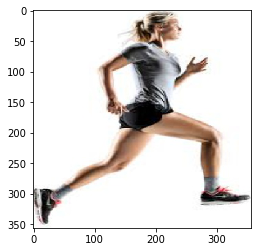

In [6]:
batch_img = batch_img.reshape([356, 356, 3])
buffer = batch_img[:,:,[2,1,0]]
preprocessed = preprocess(buffer, 356, 356)
preprocessed = preprocessed[:, :, [2,1,0]]
plt.imshow(buffer)
plt.show()

Heatmap

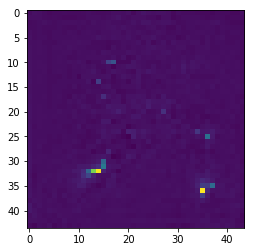

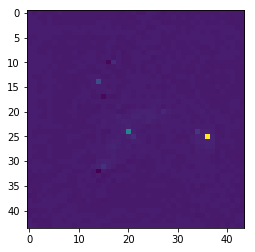

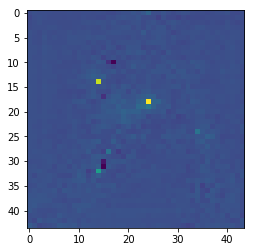

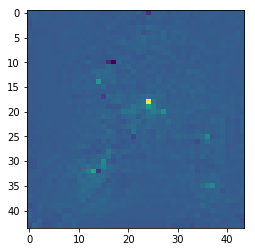

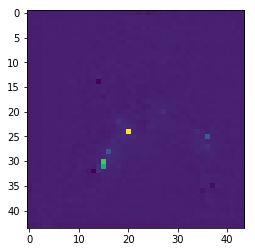

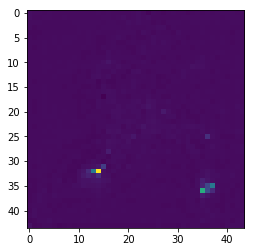

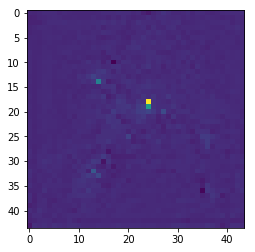

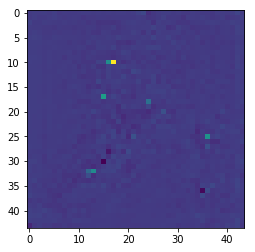

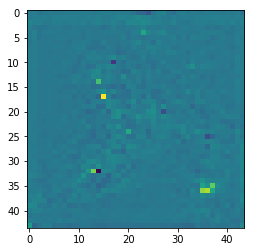

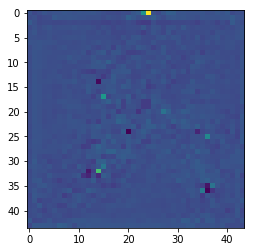

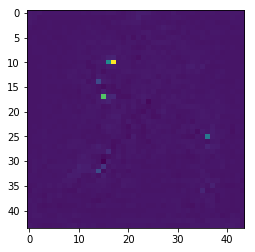

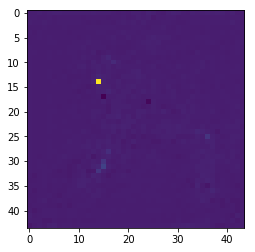

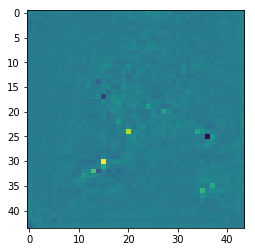

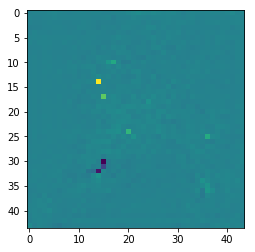

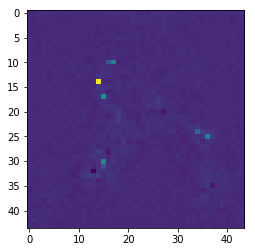

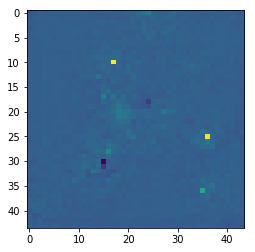

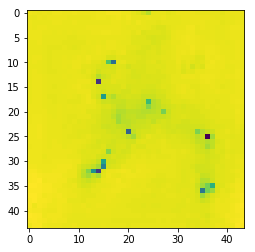

In [7]:
#heatmap
heatmap = heatmap.reshape([44, 44, 17])
heatmap_buffer = np.transpose(heatmap, (2,0, 1))

summed_heatmap = np.zeros((44, 44))
for i in range(17):
    plt.imshow(heatmap_buffer[i])
    plt.show()
#for i in range(17):
#    summed_heatmap = summed_heatmap + heatmap_buffer[i]

#print("summed_heatmap")
#plt.imshow(summed_heatmap)
#plt.show()
#summed_heatmap
#print(np.shape(summed_heatmap))

Vectormap

0


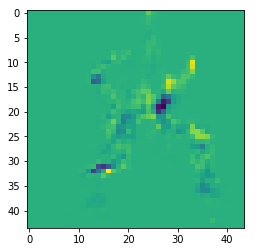

1


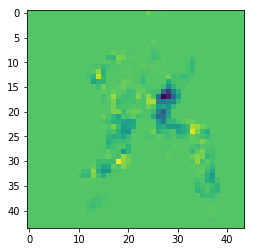

2


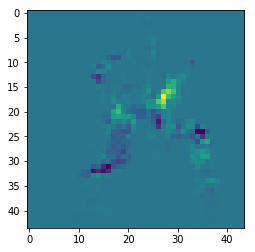

3


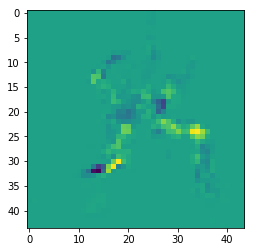

4


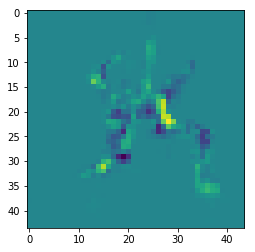

5


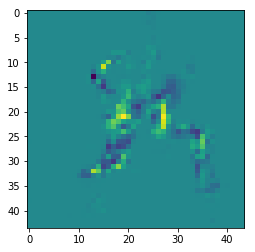

6


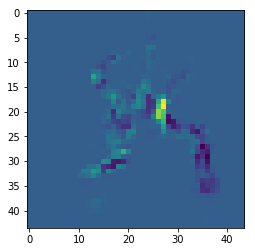

7


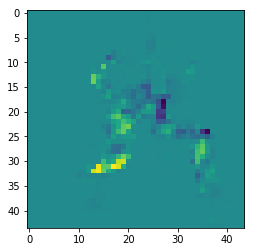

8


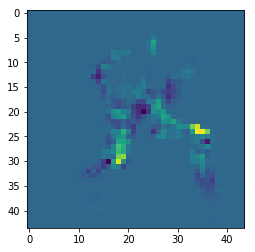

9


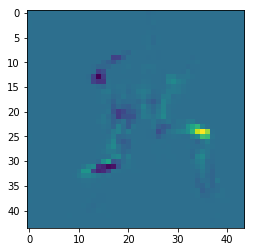

10


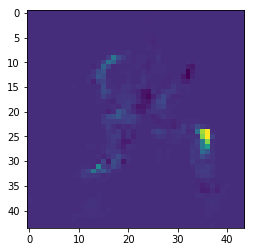

11


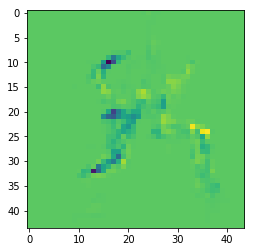

12


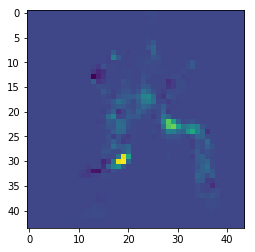

13


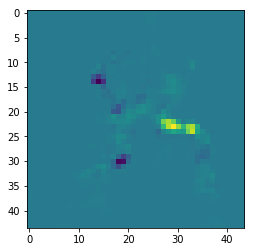

14


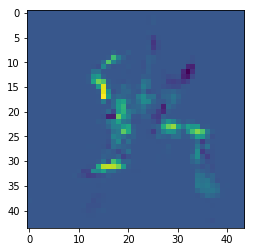

15


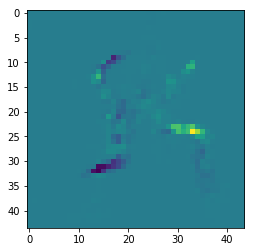

16


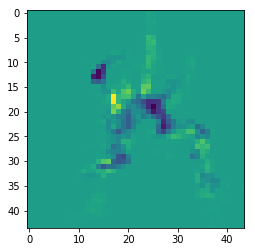

17


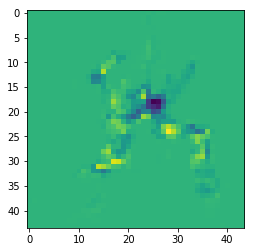

18


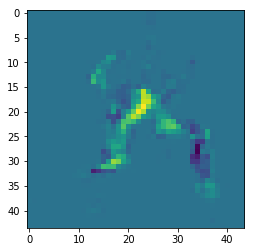

19


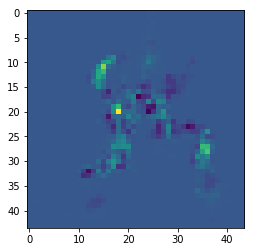

20


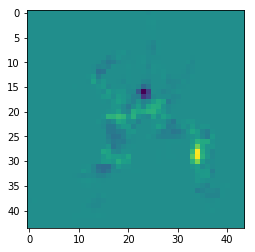

21


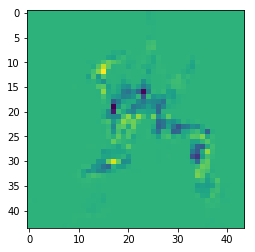

22


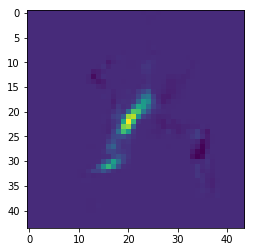

23


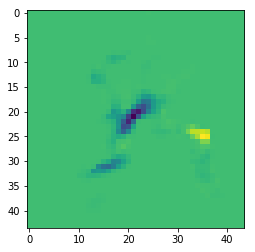

24


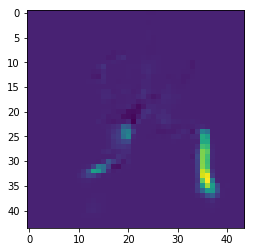

25


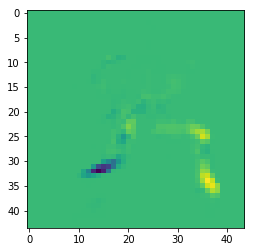

26


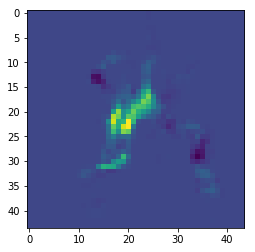

27


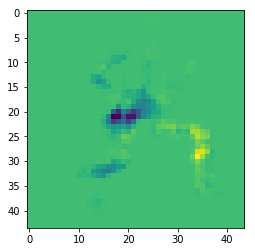

28


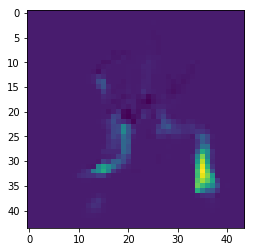

29


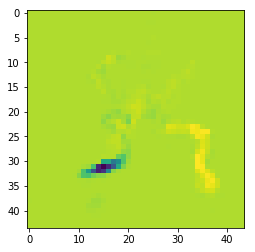

30


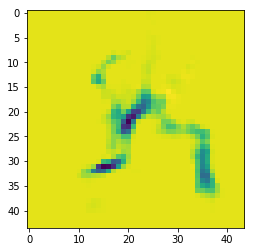

31


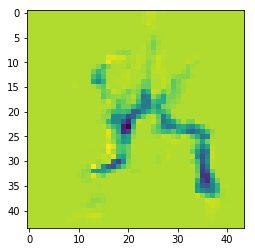

32


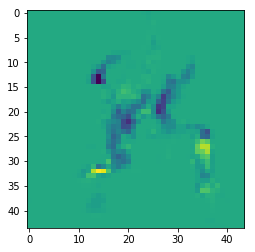

33


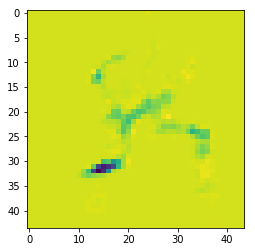

summed vectormap


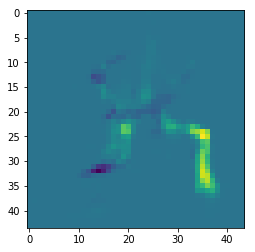

In [8]:
#vectormap
vectormap = vectormap.reshape([44, 44, 34])
vectormap_buffer = np.transpose(vectormap, (2,0, 1))

summed_vectormap = np.zeros((44, 44))
for i in range(34):
    print(i)
    plt.imshow(vectormap_buffer[i])
    plt.show()

for i in range(34):
    summed_vectormap = summed_vectormap + vectormap_buffer[i]
print("summed vectormap")
plt.imshow(summed_vectormap)
plt.show()

In [9]:
#heatmap_buffer = gaussian_filter(heatmap_buffer, sigma=10)
#vectormap_buffer = gaussian_filter(vectormap_buffer, sigma=10)

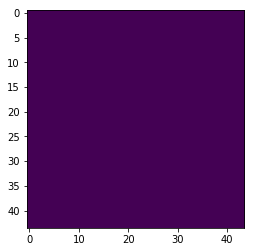

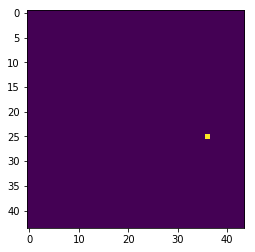

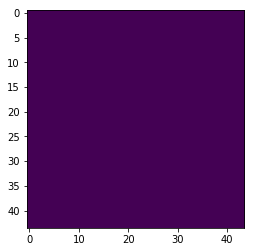

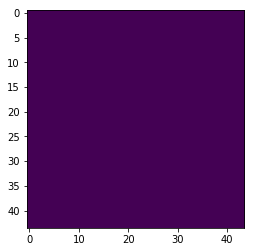

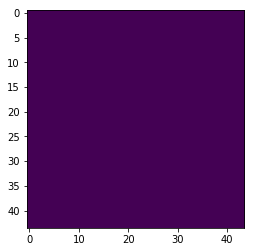

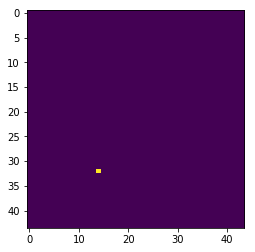

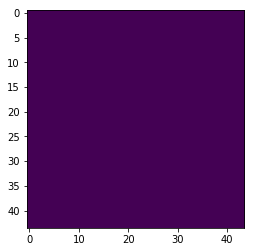

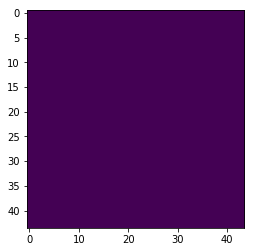

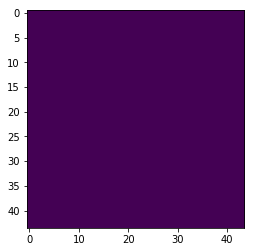

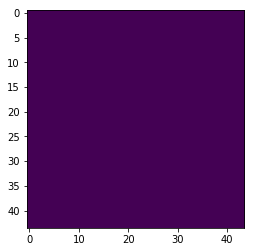

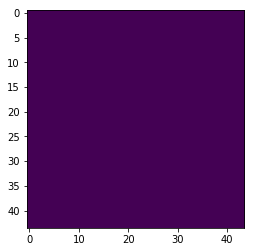

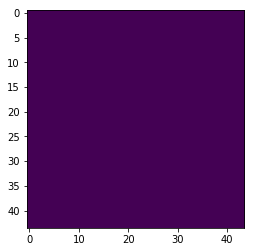

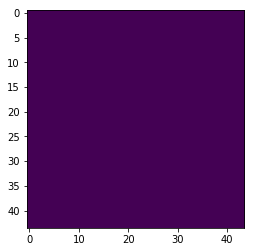

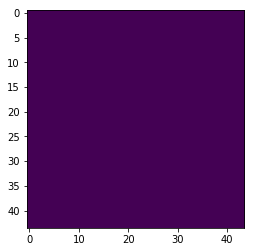

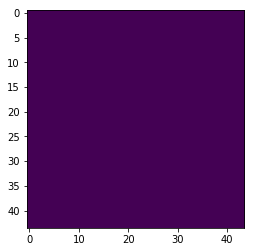

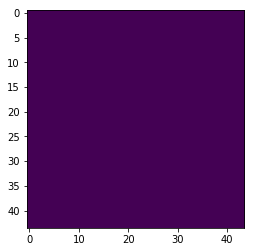

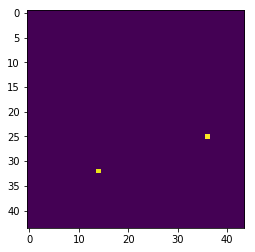

In [10]:
NMS_Threshold = 0.13
heatmap_buffer2 = heatmap_buffer - heatmap_buffer.min(axis=1).min(axis=1).reshape(17, 1, 1)
heatmap_buffer2 = heatmap_buffer - heatmap_buffer.min(axis=2).reshape(17, heatmap.shape[1], 1)
_NMS_Threshold = max(np.average(heatmap_buffer2) * 4.0, NMS_Threshold)
_NMS_Threshold = min(_NMS_Threshold, 0.3)

nms_heatmap = np.zeros((17, 44, 44))
nms_heatmap_sum = np.zeros((44, 44))
coords = []
for i in range(17-1):#except background
    nms_heatmap[i] = non_max_suppression(heatmap_buffer2[i], window_size=5, threshold=_NMS_Threshold)
    coords.append(np.where(nms_heatmap[i] >= _NMS_Threshold))
    plt.imshow(nms_heatmap[i])
    plt.show()
    
for i in range(16):
    nms_heatmap_sum = nms_heatmap_sum + nms_heatmap[i]
    
plt.imshow(nms_heatmap_sum)
plt.show()

In [11]:
coords

[(array([], dtype=int64), array([], dtype=int64)),
 (array([25], dtype=int64), array([36], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)),
 (array([32], dtype=int64), array([14], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64))]

idx1, idx2 :  9 8
paf_x_idx, paf_y_idx :  0 1
peak_coord1, peak_coord2 :  (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
idx1, idx2 :  8 13
paf_x_idx, paf_y_idx :  2 3
peak_coord1, peak_coord2 :  (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
idx1, idx2 :  8 12
paf_x_idx, paf_y_idx :  4 5
peak_coord1, peak_coord2 :  (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
idx1, idx2 :  8 7
paf_x_idx, paf_y_idx :  6 7
peak_coord1, peak_coord2 :  (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
idx1, idx2 :  12 11
paf_x_idx, paf_y_idx :  12 13
peak_coord1, peak_coord2 :  (array([], dtype=int64), array([], dtype=int64)) (array([], dtype=int64), array([], dtype=int64))
idx1, idx2 :  11 10
paf_x_idx, paf_y_idx :  14 15
peak_coord1, peak_coord2 :  (array([], dtype=int64), array([], dtype=int64)) (array(

C:\Users\JAEKYU\Anaconda3\lib\site-packages\ipykernel_launcher.py:232: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\JAEKYU\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\JAEKYU\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\JAEKYU\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\JAEKYU\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\JAEKYU\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users

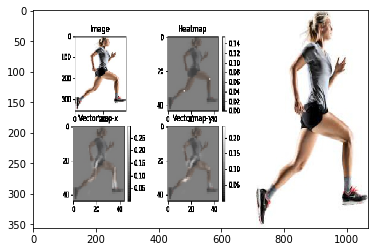

In [12]:
humans = estimate_pose(coords, heatmap_buffer, nms_heatmap, vectormap)
print("humans : ", humans)
cb_showimg(buffer, preprocessed, nms_heatmap, vectormap, humans, show_process=True)

In [13]:
data = cv2.imread('./MPII_Dataset/p2.jpg')
d = cv2.resize(data, (356, 356))
cv2.imwrite('resized_p2.jpg', d)

True